# Label ATL03 photons with ATL08 classification

In [39]:
import numpy
import pyproj

import matplotlib.pyplot as plt
import ipywidgets

from gedipy import h5io

## Open the input files

In [40]:
# Open the ATL03 file
atl03_fid = h5io.ATL03H5File('ATL03_20190212000416_06950214_003_01.h5')
atl03_fid.open()

# Open the ATL08 file
atl08_fid = h5io.ATL08H5File('ATL08_20190212000416_06950214_003_01.h5')
atl08_fid.open()

## Select a power beam

In [41]:
# Which beams are power/weak depends on the orientation of the satellite
atlas_orientation = atl03_fid.get_atlas_orientation()
if atlas_orientation == 'backward':
    power_beams = [beam for beam in atl03_fid.beams if beam.endswith('l')]
elif atlas_orientation == 'forward':
    power_beams = [beam for beam in atl03_fid.beams if beam.endswith('r')]
else:
    print('ATLAS orientation in transition, do not use')

# Select the RGT center power beam for this example
beam = power_beams[1]

# Is it night or day?
night_flag = atl08_fid.get_dataset(beam, 'land_segments/night_flag')
print('{:.2f}% of the land segments are night time'.format(numpy.sum(night_flag)/night_flag.shape[0]))

0.00% of the land segments are night time


## Extract the ATL03 photon coordinates and link with the ATL08 classification

In [30]:
longitude, latitude, elevation = atl03_fid.get_coordinates(beam, ht=True)
ph_class = atl03_fid.get_photon_labels(beam, atl08_fid)

## Convert WGS84 coordinates to the EPSG 2.0 map grid

In [42]:
inproj = pyproj.Proj(init='epsg:4326')
outproj = pyproj.Proj(init='epsg:6933')
valid = ~numpy.isnan(longitude)
valid &= ~numpy.isnan(latitude)
x,y = pyproj.transform(inproj, outproj, longitude[valid], latitude[valid])

## Plot the classified photons

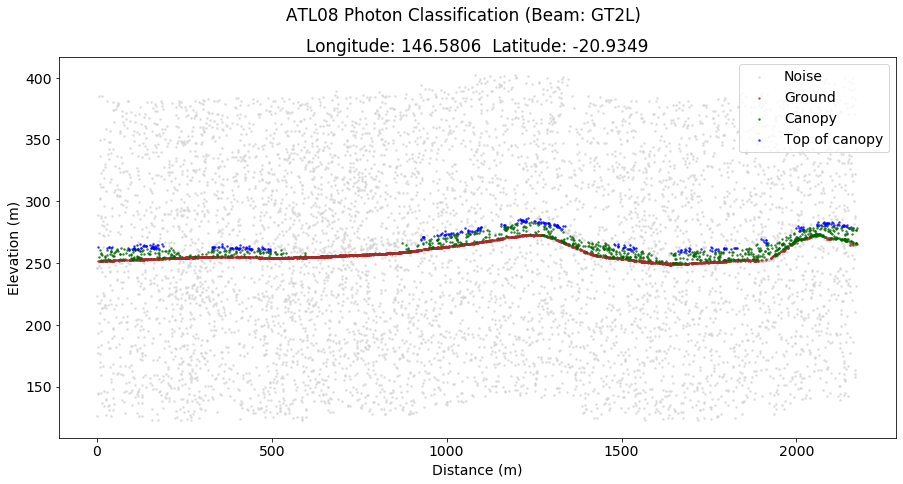

In [44]:
%matplotlib inline
plt.rcParams.update({'font.size': 14})

class_names = ['Noise','Ground','Canopy','Top of canopy']
class_color = ['lightgrey','brown','darkgreen','blue']
transect_length = 10000

def update(start=0):
    
    finish = min(start + transect_length, ph_class.shape[0])
    fig,ax = plt.subplots(1, 1, figsize=(15, 7))

    xsub = x[start:finish]
    ysub = y[start:finish]
    dist = numpy.sqrt((xsub-xsub[0])**2 + (ysub-ysub[0])**2)
    elev = elevation[valid][start:finish]
    phcl = ph_class[valid][start:finish]
    
    for i in range( len(class_names) ):
        idx = (phcl == i)
        if numpy.count_nonzero(idx) > 0:
            ax.scatter(dist[idx], elev[idx], s=6, alpha=0.8, linewidth=0,
                       c=class_color[i], label=class_names[i])
    
    ax.legend(loc='upper right')
    
    title = 'Longitude: {:.4f}  Latitude: {:.4f}'.format(longitude[start],latitude[start])
    ax.set(title=title, xlabel='Distance (m)', ylabel='Elevation (m)')
    
    fig.suptitle('ATL08 Photon Classification (Beam: {})'.format(beam.upper()))
    fig.canvas.draw()

update(start=3680000)

## Generate an interactive plot

In [45]:
nrecords = x.shape[0]
ipywidgets.interact(update, start=ipywidgets.IntSlider(min=0, max=nrecords-transect_length, 
                                                       step=transect_length, value=3680000, 
                                                       continuous_update=False))

interactive(children=(IntSlider(value=3680000, continuous_update=False, description='start', max=20539869, ste…

<function __main__.update(start=0)>